In [1]:
using FFTW
using DSP

In [2]:
include("functions.jl")

estimate_time_delay (generic function with 1 method)

In [3]:
## Load the useful math operations
include("../modules/operations.jl");

In [4]:
# this is a 5G PRACH format 0 transmission
L=839

# this is number of samples per bin, floor(L/Ncs) gives the number of cyclic shifts, see below
Ncs=26
# this is the FFT size for the generation/reception of PRACH
N=49152
# this is the length of the cyclic prefix for PRACH
Ncp=6336

6336

In [5]:
# 6-bit data messages for 3 transmitters / UEs
preamble_index1=63;
preamble_index2=31;
preamble_index3=11;

# up to 6 Zadoff-Chu root sequences for this format
utab=[129 710 140 699 120 719]

1×6 Matrix{Int64}:
 129  710  140  699  120  719

In [6]:
# number of cyclic shifts
nshifts = floor(Int, L / Ncs)
# number of Zadoff-Chu sequences required
nseq = ceil(Int, 64 / nshifts)


2

In [7]:
# index of the preamble sequence to use
uind1 = div(preamble_index1, nshifts)
uind2 = div(preamble_index2, nshifts)
uind3 = div(preamble_index3, nshifts)

# index of cyclic shift to use
nuind1 = rem(preamble_index1, nshifts)
nuind2 = rem(preamble_index2, nshifts)
nuind3 = rem(preamble_index3, nshifts)

# Check if indices are within the range of utab
if (uind1 >= length(utab) || uind2 >= length(utab) || uind3 >= length(utab))
    println("ERROR tab length ", length(utab), " : ", uind1, " ", uind2, " ", uind3)
end

In [8]:
# These are the Zadoff-Chu Sequence generators (time-domain) 
# for the 3 transmitters
xu1 = exp.(-im * π * utab[1 + uind1] * collect(0:838) .* collect(1:839) / 839)
xu2 = exp.(-im * π * utab[1 + uind2] * collect(0:838) .* collect(1:839) / 839)
xu3 = exp.(-im * π * utab[1 + uind3] * collect(0:838) .* collect(1:839) / 839)
@show size(xu1), size(xu2), size(xu3)

(size(xu1), size(xu2), size(xu3)) = ((839,), (839,), (839,))


((839,), (839,), (839,))

In [9]:
# implement cyclic-shifts
# Note: In practice, it's not common to do cyclic shifts in the time-domain and then perform FFT.
# There is a way to compute the Fourier transform directly and then perform the cyclic shift by a multiplication of a phasor in the frequency-domain.

yuv1 = zeros(Complex{Float64}, length(xu1))
yuv2 = zeros(Complex{Float64}, length(xu2))
yuv3 = zeros(Complex{Float64}, length(xu3))

# Assuming length(xu1), length(xu2), and length(xu3) are known
xuv1 = zeros(ComplexF64, length(xu1))
xuv2 = zeros(ComplexF64, length(xu2))
xuv3 = zeros(ComplexF64, length(xu3))

for n = 0:838
    xuv1[n + 1] = xu1[1 + rem(n + (Ncs * nuind1), 839)]
    yuv1 .+= fft(xuv1)
    
    xuv2[n + 1] = xu2[1 + rem(n + (Ncs * nuind2), 839)]
    yuv2 .+= fft(xuv2)
    
    xuv3[n + 1] = xu3[1 + rem(n + (Ncs * nuind3), 839)]
    yuv3 .+= fft(xuv3)
end

In [10]:
# put the PRACH in the lowest frequency (positive) subcarriers starting at carrier 7
Xuv1 = zeros(Complex{Float64}, 49152)
Xuv1[7 .+ (1:839)] .= yuv1

Xuv2 = zeros(Complex{Float64}, 49152)
Xuv2[7 .+ (1:839)] .= yuv2

Xuv3 = zeros(Complex{Float64}, 49152)
Xuv3[7 .+ (1:839)] .= yuv3;

In [11]:
# bring to time-domain
xuv1_49152 = ifft(Xuv1)
xuv2_49152 = ifft(Xuv2)
xuv3_49152 = ifft(Xuv3)
@show size(xuv1_49152), size(xuv2_49152), size(xuv3_49152)

(size(xuv1_49152), size(xuv2_49152), size(xuv3_49152)) = ((49152,), (49152,), (49152,))


((49152,), (49152,), (49152,))

In [12]:
using Plots
using LinearAlgebra

In [13]:
# add cyclic prefix
xuv1_49152 = [xuv1_49152[(end - 6335):end]; xuv1_49152]
xuv2_49152 = [xuv2_49152[(end - 6335):end]; xuv2_49152]
xuv3_49152 = [xuv3_49152[(end - 6335):end]; xuv3_49152];

In [14]:
using StatsBase

In [15]:
# normalizes the transmit signal to unit-energy
xuv1_49152 /= sqrt(sum(abs2.(xuv1_49152)) / length(xuv1_49152))
en1 = mean(abs2.(xuv1_49152))
xuv2_49152 /= sqrt(sum(abs2.(xuv2_49152)) / length(xuv2_49152))
en2 = mean(abs2.(xuv2_49152))
xuv3_49152 /= sqrt(sum(abs2.(xuv3_49152)) / length(xuv3_49152))
en3 = mean(abs2.(xuv3_49152))

1.0

#### Plot the time-domain and frequency-domain waveform (xuv1)

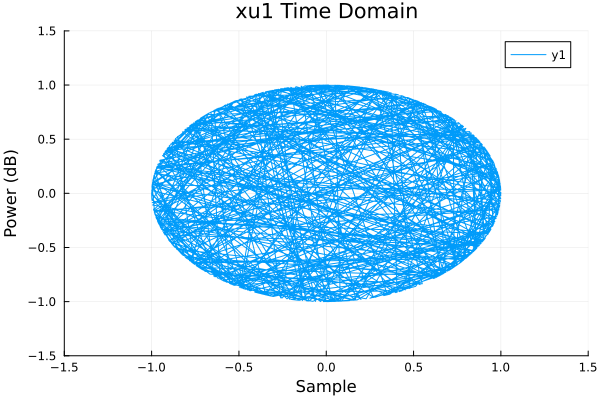

In [16]:
# Plot the result
# xuv1_plot = 
plot(xu1
    , xlabel="Sample", ylabel="Power (dB)"
    , title="xu1 Time Domain"
    , ylim=(-3/2, 3/2)
    , xlim=(-3/2, 3/2)
)
# savefig(xuv1_plot,"images/xuv1_plot.png");

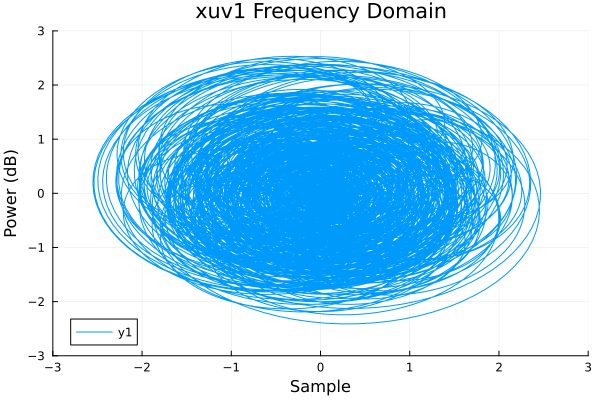

In [17]:
# Plot the result
# xuv1_plot = 
plot(xuv1_49152
    , xlabel="Sample", ylabel="Power (dB)"
    , title="xuv1 Frequency Domain"
    , ylim=(-3, 3)
    , xlim=(-3, 3)
)
# savefig(xuv1_plot,"images/xuv1_plot.png");

#### Question: What can you say regarding the frequency span (approximately how many PRBs does this waveform occupy

In [18]:
# simulate time-delay
delay1 = 300
delay2 = 140
delay3 = 40
delaymax = 1 + maximum([delay1, delay2, delay3])

301

In [21]:
xuv1_49152 = [zeros(1, delay1); xuv1_49152; zeros(1, delaymax - delay1)]

# xuv1_49152 = vcat(zeros(ComplexF64, 1, delay1), xuv1_49152, zeros(ComplexF64, 1, delaymax - delay1))

# xuv1_49152 = vcat(zeros(ComplexF64, 1, delay1), xuv1_49152, zeros(ComplexF64, 1, delaymax - delay1))
# xuv2_49152 = vcat(zeros(ComplexF64, 1, delay2), xuv2_49152, zeros(ComplexF64, 1, delaymax - delay2))
# xuv3_49152 = vcat(zeros(ComplexF64, 1, delay3), xuv3_49152, zeros(ComplexF64, 1, delaymax - delay3))

# xuv1_49152 = xuv1_49152[(delaymax-delay1):delaymax] ⧺ xuv1_49152 ; @show size(xuv1_49152)
# xuv2_49152 = xuv2_49152[(delaymax-delay2):delaymax] ⧺ xuv2_49152 ; @show size(xuv2_49152)
# xuv3_49152 = xuv3_49152[(delaymax-delay3):delaymax] ⧺ xuv3_49152 ; @show size(xuv3_49152);

LoadError: DimensionMismatch: number of columns of each array must match (got (300, 1, 1))

In [85]:
using Random

# Assuming xuv1_49152, xuv2_49152, xuv3_49152 are already defined

SNR = 0
snr = 10^(0.1 * SNR)

# Generate complex Gaussian noise
noise1 = sqrt(0.5 / snr) * (randn(Complex{Float64}, length(xuv1_49152)) + 1im * randn(Complex{Float64}, length(xuv1_49152)))
noise2 = sqrt(0.5 / snr) * (randn(Complex{Float64}, length(xuv1_49152)) + 1im * randn(Complex{Float64}, length(xuv1_49152)));

In [88]:
# Add noise to signals
rxsig1_justnoise = xuv1_49152 + noise1
rxsig2_justnoise = xuv1_49152 + xuv2_49152 + noise2 # xuv2_49152 + xuv3_49152 + noise2;

LoadError: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(62125),), b has dims (Base.OneTo(61965),), mismatch at 1

In [44]:
include("get_tld.jl")

get_tdl (generic function with 1 method)

In [45]:
# Assuming get_tdl function is defined

fs = 61.44e6
SCS = 30e3
DS = 300e-9

H1 = get_tdl(fs, SCS, 0:105, DS, "tdlc")
H2 = get_tdl(fs, SCS, 0:105, DS, "tdlc")
H3 = get_tdl(fs, SCS, 0:105, DS, "tdlc");


In [52]:
## Prepare the template signal for convolution
H1̅ = ⦰(H1); # reverse #typed H\overbar
H1̅ᴴ = conj(H1̅); # conjugate 
@show length(H1̅ᴴ);

length(H1̅ᴴ) = 3816


In [53]:
rxsig3_noiseandchannel = (xuv1_49152 ⊗ H1̅ᴴ)
# rxsig3_noiseandchannel .= rxsig3_noiseandchannel .+ sqrt(0.5 / snr) * (randn(ComplexF64, length(rxsig3_noiseandchannel)) + 1im * randn(ComplexF64, length(rxsig3_noiseandchannel)))

# rxsig4_noiseandchannel = (H1 ⊗ xuv1_49152) .+ (H2 ⊗ xuv2_49152) .+ (H3 ⊗ xuv3_49152)
# rxsig4_noiseandchannel .= rxsig4_noiseandchannel .+ sqrt(0.5 / snr) * (randn(ComplexF64, length(rxsig4_noiseandchannel)) + 1im * randn(ComplexF64, length(rxsig4_noiseandchannel)))


LoadError: MethodError: no method matching conv(::Vector{ComplexF64}, ::Matrix{Vector{ComplexF64}})

[0mClosest candidates are:
[0m  conv(::AbstractVector{T}, [91m::AbstractVector{T}[39m, [91m::AbstractMatrix{T}[39m) where T
[0m[90m   @[39m [36mDSP[39m [90m~/.julia/packages/DSP/H0J1V/src/[39m[90m[4mdspbase.jl:740[24m[39m
[0m  conv(::AbstractArray{T, N}, [91m::AbstractArray{T, N}[39m) where {T<:Union{AbstractFloat, Complex{T} where T<:AbstractFloat}, N}
[0m[90m   @[39m [36mDSP[39m [90m~/.julia/packages/DSP/H0J1V/src/[39m[90m[4mdspbase.jl:690[24m[39m
[0m  conv(::AbstractArray{<:Union{AbstractFloat, Complex{T} where T<:AbstractFloat}, N}, [91m::AbstractArray{<:Union{AbstractFloat, Complex{T} where T<:AbstractFloat}, N}[39m) where N
[0m[90m   @[39m [36mDSP[39m [90m~/.julia/packages/DSP/H0J1V/src/[39m[90m[4mdspbase.jl:701[24m[39m
[0m  ...
